In [13]:
import cv2
import json
import math
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import tqdm

from pathlib import Path
from PIL import Image

%matplotlib inline

cwd = Path.cwd()
data_folder = Path(cwd, 'dataset-sample')
reg_data_folder = Path(cwd, 'reg-data')

In [14]:
LABEL_IMG_PATTERN = '.*\.(JPG|png)'
LABEL_MASK_PATTERN = '.*\.json'
MSI_IMG_PATTERN = '.*\.png'


class Sample:

    def __init__(self, data_folder, sample_info):
        self.data_folder = data_folder
        self.id = None
        self.sample_path = None
        self.references = None
        self.data = None
        self._init_sample_info(sample_info)

    def _init_sample_info(self, sample_info):
        self.id = sample_info.get('id')
        self.sample_path = Path(self.data_folder, self.id)
        self.references = sample_info.get('ref_runs')
        self.data = sample_info.get('data_runs')

    def __repr__(self):
        return f"Sample(id={self.id})"
    
    # Data Images
    def get_data_paths(self, with_cap=True):
        """Return list of key-value pairs of label image and run image paths.
        
        Return: [
            {
                'label_img_path': Path,
                'label_mask_path': Path,
                'run_img_paths': [Path, Path, ...]
            },
        ]
        """
        
        labelled_folder = self.data.get('capillary').get('included') if with_cap else self.data.get('capillary').get('excluded')
        labelled_img_path = Path(self.sample_path, 'Labelling data', 'Definitive segmentation', labelled_folder)
        if not labelled_img_path.exists():
            labelled_img_path = Path(self.sample_path, 'Labelling data', 'Definitive segmentations', labelled_folder)

        paths = []
        run_group = self.data.get('runs').keys()
        for group in run_group:
            group_path = Path(labelled_img_path, group)
            label_img_path = [x for x in group_path.iterdir() if re.match(LABEL_IMG_PATTERN, x.name)][0]
            label_mask_path = [x for x in group_path.iterdir() if re.match(LABEL_MASK_PATTERN, x.name)][0]

            run_ids = self.data.get('runs').get(group)
            for run_id in run_ids:
                run_path = Path(data_folder, self.id, run_id)
                run_img_paths = [x for x in run_path.iterdir() if re.match(MSI_IMG_PATTERN, x.name)]

                paths.append({
                    'label_img_path': label_img_path,
                    'label_mask_path': label_mask_path,
                    'run_img_paths': sorted(run_img_paths)
                })
        
        return paths

    # Reference Images
    def get_reference_paths(self):
        """Return list of key-value pairs of reference image paths.
        
        Return: {
            'orient': Path,
            'white': Path,
            'dark': Path
        }
        """
        
        paths = {}
        ref_imgs = self.references.keys()
        for ref_img in ref_imgs:
            run_ids = self.references.get(ref_img)
            run_paths = [Path(data_folder, self.id, run_id) for run_id in run_ids]
            run_img_paths = [x for x in run_paths[0].iterdir() if re.match(MSI_IMG_PATTERN, x.name)]

            paths[ref_img] = sorted(run_img_paths)
        
        return paths
    
    # Reference Images
    @property
    def orient_ref_path(self):
        return self.get_reference_paths().get('orient')

    @property
    def white_ref_path(self):
        return self.get_reference_paths().get('white')

    @property
    def dark_ref_path(self):
        return self.get_reference_paths().get('dark')


sample_infos = json.load(Path(data_folder, 'hs-info.json').open())
samples = [Sample(data_folder, sample_info) for sample_info in sample_infos.get('data')]

/Users/farhanoktavian/imperial/thesis/sandbox/preprocess_extract/dataset-sample/HS003/Labelling data/Definitive segmentation/HS003 - capillary included/Run 08-12/Patient_1  12-06-13.JPG
/Users/farhanoktavian/imperial/thesis/sandbox/preprocess_extract/dataset-sample/HS003/Run09/image sample 560nm 1.png


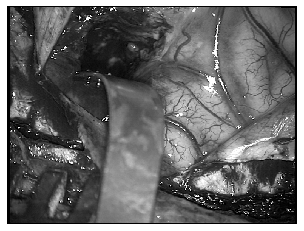

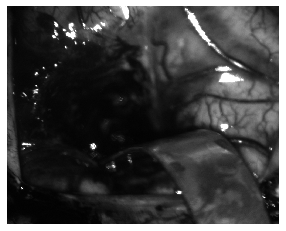

In [15]:
def get_560nm_img(img_paths):
    img_path = [x for x in img_paths if '560' in x.name][0]
    return img_path


def register(source_img, target_img):
    sift = cv2.SIFT_create()

    # Find keypoints
    source_img_cp = cv2.equalizeHist(source_img)
    target_img_cp = cv2.equalizeHist(target_img)   
    kp_1, desc_1 = sift.detectAndCompute(source_img_cp, None)
    kp_2, desc_2 = sift.detectAndCompute(target_img_cp, None)

    # # brute force feature matching
    # bf = cv2.BFMatcher()
    # matches = bf.knnMatch(desc_1, desc_2, k=2)

    # flann feature matching
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc_1, desc_2, k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    MIN_MATCH_COUNT = 7
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([ kp_1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)
    img3 = cv2.drawMatches(source_img, kp_1, target_img, kp_2, good, None, **draw_params)

    return cv2.warpPerspective(source_img, M, (target_img.shape[1], target_img.shape[0]))


test_sample = samples[2]
test_runs = test_sample.get_data_paths()[3]

source_img = test_runs.get('label_img_path')
print(source_img)
# source_img = np.asarray(Image.open(source_img).convert('L'))
source_img = np.asarray(Image.open(source_img).getchannel('G'))
source_img = cv2.flip(source_img, 0)
# source_img = cv2.rotate(source_img, cv2.ROTATE_90_CLOCKWISE)

target_img = get_560nm_img(test_runs.get('run_img_paths'))
print(target_img)
target_img = np.asarray(Image.open(target_img).convert('L'))


fig, ax = plt.subplots()
ax.imshow(source_img, 'gray')
ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(target_img, 'gray')
ax.axis('off')

tgt_warped = register(source_img, target_img)

PSNR: 14.31683673865044
PSNR same: 36.51737632642569


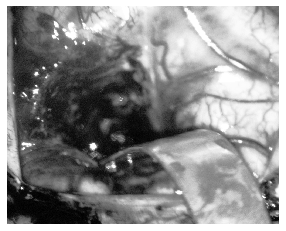

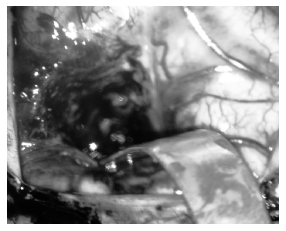

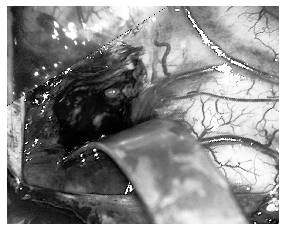

In [16]:
img_a = target_img.copy()
img_a = cv2.equalizeHist(img_a)
img_a_blur = cv2.GaussianBlur(img_a, (5, 5), 2)

img_b = tgt_warped.copy()
# fill zero values img_b with img_a
img_b = cv2.equalizeHist(img_b)
img_b[img_b == 0] = img_a[img_b == 0]


fig, ax = plt.subplots()
ax.imshow(img_a, 'gray')
ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(img_a_blur, 'gray')
ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(img_b, 'gray')
ax.axis('off')

print(f"PSNR: {cv2.PSNR(img_a, img_b)}")
print(f"PSNR same: {cv2.PSNR(img_a, img_a_blur)}")


In [17]:
import numpy as np
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric, CCMetric
import dipy.align.imwarp as imwarp
from dipy.data import get_fnames
from dipy.io.image import load_nifti_data
from dipy.segment.mask import median_otsu
from dipy.viz import regtools


def callback_CC(sdr, status):
    # Status indicates at which stage of the optimization we currently are
    # For now, we will only react at the end of each resolution of the scale
    if status == imwarp.RegistrationStages.SCALE_END:
        # get the current images from the metric
        wmoving = sdr.metric.moving_image
        wstatic = sdr.metric.static_image
        # draw the images on top of each other with different colors
        regtools.overlay_images(wmoving, wstatic, 'Warped moving', 'Overlay',
                                'Warped static')
        

def reg_bspline(source, target):
    sigma_diff = 3.0
    radius = 4
    metric = CCMetric(2, sigma_diff, radius)

    level_iters = [100, 50, 25]
    sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)
    sdr.callback = callback_CC
    mapping = sdr.optimize(source, target)
    warped = mapping.transform(source, 'linear')
    return warped

Running iteration 0
0 0
Running iteration 1
5 15
Running iteration 2
0 9
Running iteration 3
0 12
Running iteration 4
1 2
Running iteration 5
2 1
Not enough matches are found - 7/7
local variable 'M' referenced before assignment
Running iteration 6
5 6
Running iteration 7
3 4
Running iteration 8
3 0
Running iteration 9
0 3


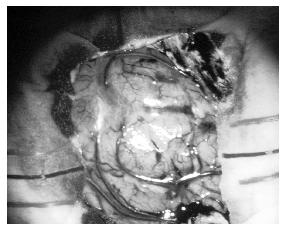

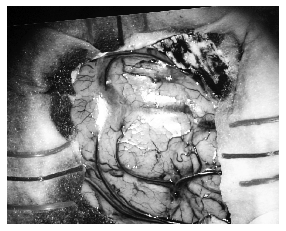

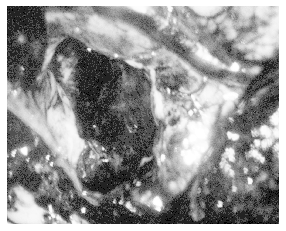

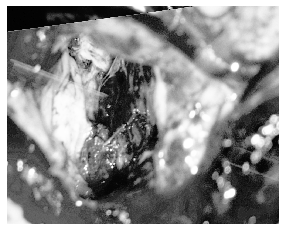

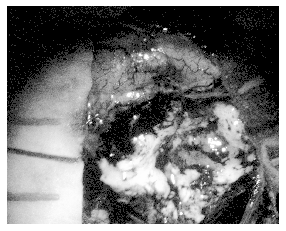

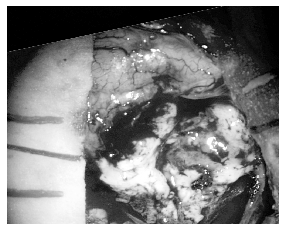

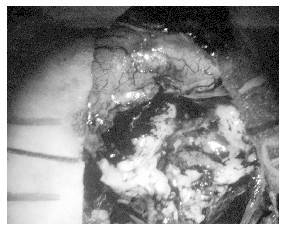

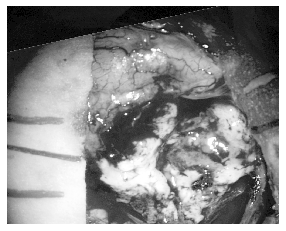

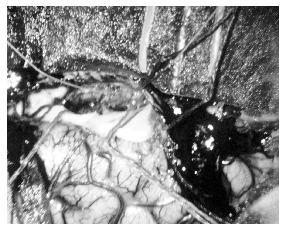

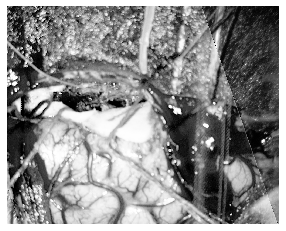

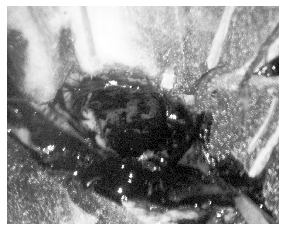

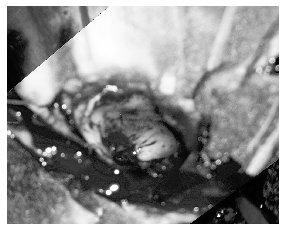

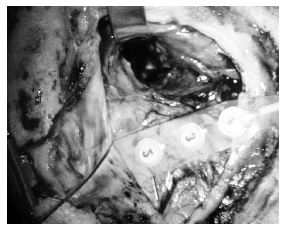

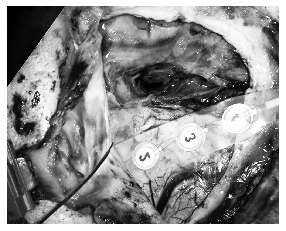

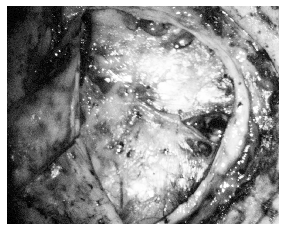

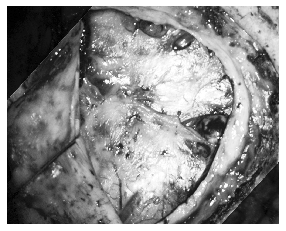

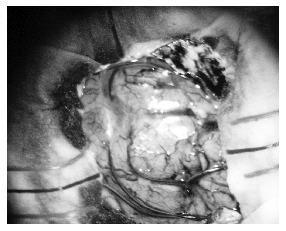

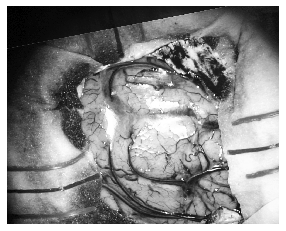

In [20]:
this_samples = [samples[0]] + samples[2:]
registered_images = []
res = ""
for i in range(10):
    try:
        print(f"Running iteration {i}")
        rand_sample = random.randint(0, len(this_samples))
        test_sample = samples[rand_sample]

        rand_run = random.randint(0, len(test_sample.get_data_paths()))
        test_runs = test_sample.get_data_paths()[rand_run]
        print(rand_sample, rand_run)


        source_img = test_runs.get('label_img_path')
        try:
            source_img = np.asarray(Image.open(source_img).getchannel('G'))
        except Exception as e:
            source_img = np.asarray(Image.open(source_img).convert('L'))
        source_img = cv2.flip(source_img, 0)

        target_img = get_560nm_img(test_runs.get('run_img_paths'))
        target_img = np.asarray(Image.open(target_img).convert('L'))

        tgt_warped = register(source_img, target_img)
        # tgt_warped = reg_bspline(source_img, tgt_warped)

        img_a = target_img.copy()
        img_b = tgt_warped.copy()
        img_b[img_b == 0] = img_a[img_b == 0]

        registered_images.append((img_a, img_b))

        fig, ax = plt.subplots()
        ax.imshow(cv2.equalizeHist(img_a), 'gray')
        ax.axis('off')

        fig, ax = plt.subplots()
        ax.imshow(cv2.equalizeHist(img_b), 'gray')
        ax.axis('off')

        res += f"PSNR {test_sample.id}: {cv2.PSNR(img_a, img_b)}\n"
    except Exception as e:
        print(e)
        # print(f"Error at {test_sample.id}, image {get_560nm_img(test_runs.get('run_img_paths'))}")
        pass
    